In [1]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import librosa
import math

from scipy.ndimage import generate_binary_structure
from scipy.ndimage import iterate_structure

from typing import Tuple, List

from numba import njit

In [2]:
# https://github.com/Sarcovora/CogWorks-2022-Gausslien-Audio-Capstone/blob/main/CogZam/peakExtraction.py

@njit
def _peaks(
    data_2d: np.ndarray, nbrhd_row_offsets: np.ndarray, nbrhd_col_offsets: np.ndarray, amp_min: float
) -> List[Tuple[int, int]]:
    """
    A Numba-optimized 2-D peak-finding algorithm.
    
    Parameters
    ----------
    data_2d : numpy.ndarray, shape-(H, W)
        The 2D array of data in which local peaks will be detected.

    nbrhd_row_offsets : numpy.ndarray, shape-(N,)
        The row-index offsets used to traverse the local neighborhood.
        
        E.g., given the row/col-offsets (dr, dc), the element at 
        index (r+dr, c+dc) will reside in the neighborhood centered at (r, c).
    
    nbrhd_col_offsets : numpy.ndarray, shape-(N,)
        The col-index offsets used to traverse the local neighborhood. See
        `nbrhd_row_offsets` for more details.
        
    amp_min : float
        All amplitudes equal to or below this value are excluded from being
        local peaks.
    
    Returns
    -------
    List[Tuple[int, int]]
        (row, col) index pair for each local peak location, returned in 
        column-major order
    """
    peaks = []  # stores the (row, col) locations of all the local peaks

    # Iterating over each element in the the 2-D data 
    # in column-major ordering
    #
    # We want to see if there is a local peak located at
    # row=r, col=c
    for c, r in np.ndindex(*data_2d.shape[::-1]):
        if data_2d[r, c] <= amp_min:
            # The amplitude falls beneath the minimum threshold
            # thus this can't be a peak.
            continue
        
        # Iterating over the neighborhood centered on (r, c) to see
        # if (r, c) is associated with the largest value in that
        # neighborhood.
        #
        # dr: offset from r to visit neighbor
        # dc: offset from c to visit neighbor
        for dr, dc in zip(nbrhd_row_offsets, nbrhd_col_offsets):
            if dr == 0 and dc == 0:
                # This would compare (r, c) with itself.. skip!
                continue

            if not (0 <= r + dr < data_2d.shape[0]):
                # neighbor falls outside of boundary.. skip!
                continue

            if not (0 <= c + dc < data_2d.shape[1]):
                # neighbor falls outside of boundary.. skip!
                continue

            if data_2d[r, c] < data_2d[r + dr, c + dc]:
                # One of the amplitudes within the neighborhood
                # is larger, thus data_2d[r, c] cannot be a peak
                break
        else:
            # if we did not break from the for-loop then (r, c) is a local peak
            peaks.append((r, c))
    return peaks

In [3]:
# https://github.com/Sarcovora/CogWorks-2022-Gausslien-Audio-Capstone/blob/main/CogZam/peakExtraction.py

def local_peak_locations(data_2d: np.ndarray, neighborhood: np.ndarray, amp_min: float):
    """
    Defines a local neighborhood and finds the local peaks
    in the spectrogram, which must be larger than the specified `amp_min`.
    
    Parameters
    ----------
    data_2d : numpy.ndarray, shape-(H, W)
        The 2D array of data in which local peaks will be detected
    
    neighborhood : numpy.ndarray, shape-(h, w)
        A boolean mask indicating the "neighborhood" in which each
        datum will be assessed to determine whether or not it is
        a local peak. h and w must be odd-valued numbers
        
    amp_min : float
        All amplitudes at and below this value are excluded from being local 
        peaks.
    
    Returns
    -------
    List[Tuple[int, int]]
        (row, col) index pair for each local peak location, returned
        in column-major ordering.
    
    Notes
    -----
    The local peaks are returned in column-major order, meaning that we 
    iterate over all nbrhd_row_offsets in a given column of `data_2d` in search for
    local peaks, and then move to the next column.
    """

    # We always want our neighborhood to have an odd number
    # of nbrhd_row_offsets and nbrhd_col_offsets so that it has a distinct center element
    assert neighborhood.shape[0] % 2 == 1
    assert neighborhood.shape[1] % 2 == 1
    
    # Find the indices of the 2D neighborhood where the 
    # values were `True`
    #
    # E.g. (row[i], col[i]) stores the row-col index for
    # the ith True value in the neighborhood (going in row-major order)
    nbrhd_row_indices, nbrhd_col_indices = np.where(neighborhood)
    

    # Shift the neighbor indices so that the center element resides 
    # at coordinate (0, 0) and that the center's neighbors are represented
    # by "offsets" from this center element.
    #
    # E.g., the neighbor above the center will has the offset (-1, 0), and 
    # the neighbor to the right of the center will have the offset (0, 1).
    nbrhd_row_offsets = nbrhd_row_indices - neighborhood.shape[0] // 2
    nbrhd_col_offsets = nbrhd_col_indices - neighborhood.shape[1] // 2

    return _peaks(data_2d, nbrhd_row_offsets, nbrhd_col_offsets, amp_min=amp_min)

In [4]:
# https://github.com/Sarcovora/CogWorks-2022-Gausslien-Audio-Capstone/blob/main/CogZam/peakExtraction.py

def find_min_amp(spectrogram, amp_threshold):
    log_S = np.log(spectrogram).ravel()  # flattened array
    ind = round(len(log_S) * amp_threshold) # find index associated with the amp_threshold percentile log amplitude
    cutoff_log_amplitude = np.partition(log_S, ind)[ind]
    return cutoff_log_amplitude

In [5]:
# https://github.com/Sarcovora/CogWorks-2022-Gausslien-Audio-Capstone/blob/main/CogZam/peakExtraction.py

def peak_extract(samples, sampling_rate, *, amp_threshold=0.75, neighborhood_rank=2, neighborhood_connectivity=1, neighborhood_iterations=20):
    """
    Extracts peaks from a spectrogram created from the sample data.
    
    Parameters
    ----------
    samples : numpy.ndarray
        Array of audio samples
    
    sampling_rate : int
        The sampling rate of the audio samples
        
    amp_threshold : float
        All amplitudes at and below this value are excluded from being local 
        peaks.

    neighborhood_rank : int

    neighborhood_connectivity : int

    neighborhood_iterations : int
    
    Returns
    -------
    List[Tuple[int, int]]
        (row, col) index pair for each local peak location, returned
        in column-major ordering.
    """
    
    time = np.arange(len(samples)) / sampling_rate

    base_structure = generate_binary_structure(neighborhood_rank,neighborhood_connectivity)
    neighborhood = iterate_structure(base_structure, neighborhood_iterations)

    spectrogram, freqs, times = mlab.specgram(
        samples,
        NFFT=4096,
        Fs=sampling_rate,
        window=mlab.window_hanning,
        noverlap=int(4096 / 2)
    )

    spectrogram = np.clip(spectrogram, 10**-20, None)
    
    amp_min = find_min_amp(spectrogram, amp_threshold)

    return local_peak_locations(spectrogram, neighborhood, amp_min)

In [6]:
path = "..\Downloads\songs\Bach - Cello Suite No. 1 in G Major BWV1007 - Mov. 1-3_6-[zipza.com].mp3"
aud, sr = librosa.load(path, sr=44100, mono=True, offset=5.0) # Music doesn't play until 5 seconds in to the video

In [7]:
peaks = peak_extract(aud, sr)
#print(peaks)

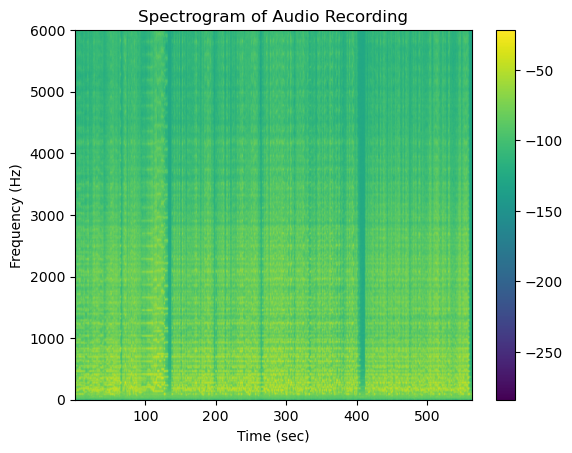

In [8]:
fig, ax = plt.subplots()

S, freqs, times, im = ax.specgram(
    aud,
    NFFT=4096,
    Fs=sr,
    window=mlab.window_hanning,
    noverlap=4096 // 2,
)
fig.colorbar(im)

ax.set_xlabel("Time (sec)")
ax.set_ylabel("Frequency (Hz)")
ax.set_title("Spectrogram of Audio Recording")
ax.set_ylim(0, 6000);

In [9]:
def average_distance_between_peaks(peaks):
    distances = []
    peaks = np.fft.fft(peaks) # Fast Fourier Transform
    for t, i in enumerate(peaks):
        if ((t + 1) != len(peaks)):
            distances.append(math.sqrt(((peaks[t + 1][0] - peaks[t][0]) ** 2) + ((peaks[t + 1][1] - peaks[t][1]) ** 2)))
            # Find distance between peaks using distance formula (sqrt((x2-x1)^2 + (y2-y1)^2))
    return sum(distances)/len(distances)   

In [10]:
ave = average_distance_between_peaks(peaks)
bpm = (60/ave)
print(bpm) # Just wrong
print(ave)

0.3547260652697197
169.1446044552107


C:\Users\nketi\AppData\Local\Temp\ipykernel_9764\1546272634.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  distances.append(math.sqrt(((peaks[t + 1][0] - peaks[t][0]) ** 2) + ((peaks[t + 1][1] - peaks[t][1]) ** 2)))


In [11]:
dur = librosa.get_duration(y=aud, sr=sr)
bpm2 = (len(peaks)/dur)
print(bpm2) # It's closer and more accurate when the whole song is played, otherwise completely off

108.78184924701833
